In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt


G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

In [2]:
# load data
TrainingData = scio.loadmat('../generate_ligo/noise.mat') # only noise    
analysisData = scio.loadmat('../generate_ligo/data.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
# dataY = analysisData['dataVec'][0] # (2048,)
dataY = analysisData['data'][0]
# dataY = analysisData['trainData'][0] # (2048,)1
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
# Fs = analysisData['sampFreq'][0,0] # 1024
Fs = analysisData['samples'][0]
# Fs = 1024

# Search range of phase coefficients
"""
        r,   m_c, tc,  phi_c,  mlz,   y
"""
rmin = [1e20,1e31,-1,-2 * np.pi,1e36,0]
rmax = [1e25,2e31,1,2*np.pi,1e37,0.5]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
# t = np.arange(0, nSamples*dt, dt) # (2048,)
t = np.linspace(-40,0,nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['noise'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)
print(dataY.size)

199998


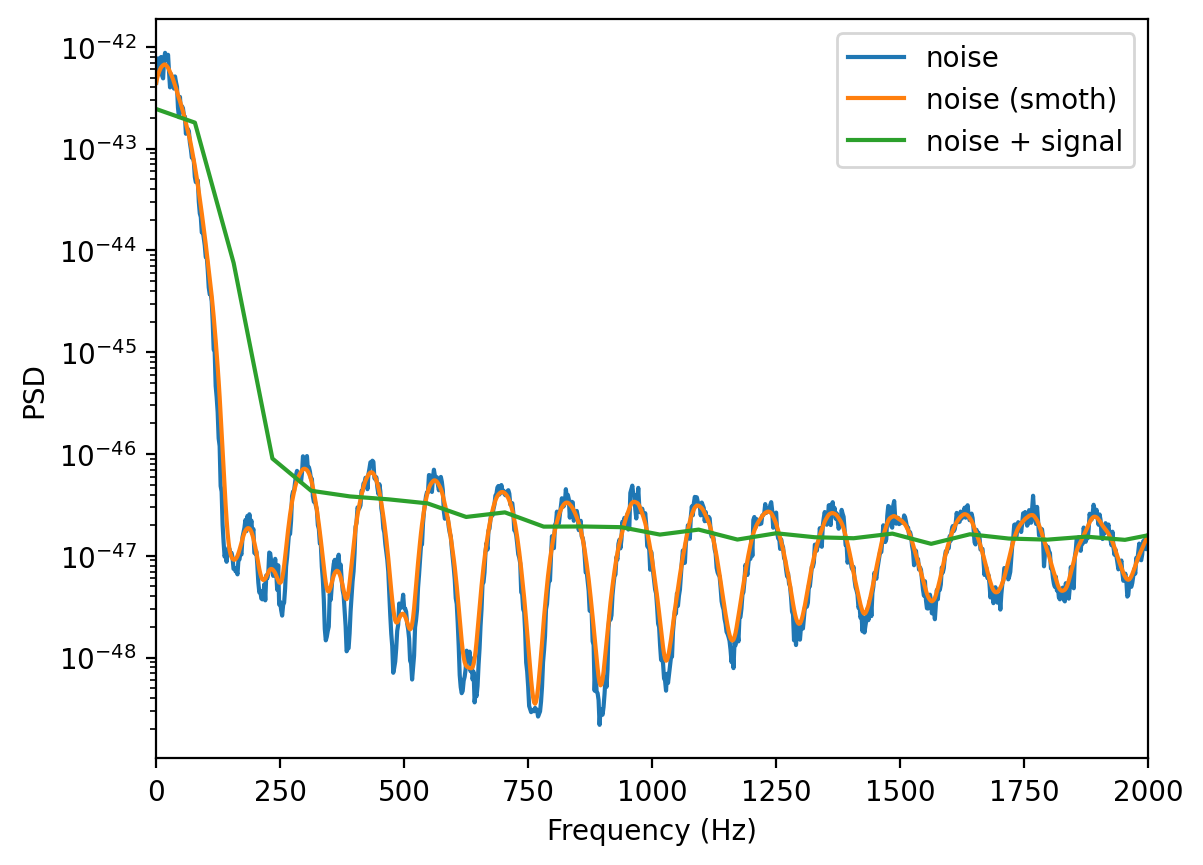

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smooth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(np.abs(f),pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0,2000)
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    # 'dataXSq': t**2,
    # 'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from itsw
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:299: RuntimeWarning: invalid value encountered in power
  h = G * m_c / (c ** 2 * r) * theta ** (-1/4) * np.cos(2 * phi_c - 2 * theta ** (5 / 8))
100%|██████████| 2000/2000 [1:29:51<00:00,  2.70s/it]


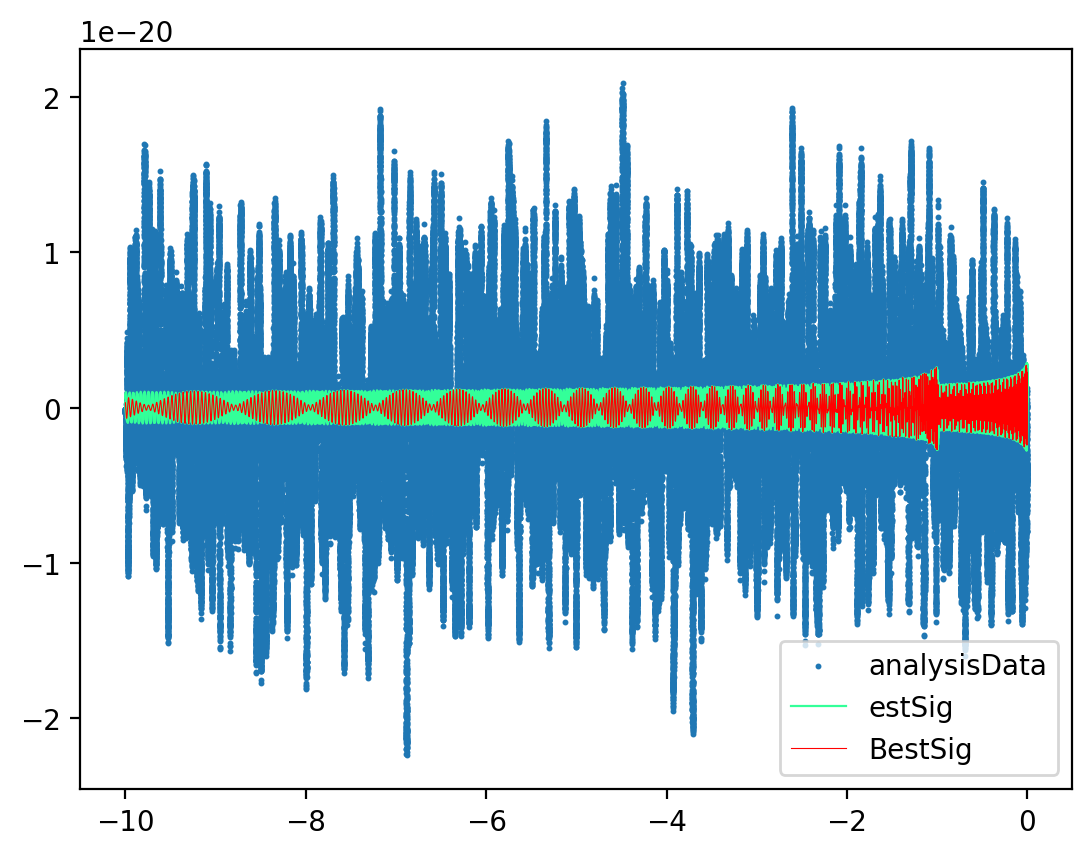

In [6]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         'red',lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
# print(outResults['allRunsOutput'][lpruns]['estSig'])

In [7]:
# Print estimated parameters
print('Estimated parameters:')
print('bestFitness = {:.4f}'.format(outResults['bestFitness']))
print('r = {:.4e}'.format(outResults['r']))
print('m_c = {:.4e}'.format(outResults['m_c'])) 
print('tc = {:.4f}'.format(outResults['tc']))
print('phi_c = {:.4f}'.format(outResults['phi_c']))
print('mlz = {:.4e}'.format(outResults['mlz']))
print('y = {:.4f}'.format(outResults['y']))

for lpruns in range(nRuns):
    print('\nRun No.{}:'.format(lpruns+1))
    print('bestFitness={:.2f}'.format(outStruct[lpruns]['bestFitness']))
    print('r = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['r']))
    print('m_c = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['m_c']))
    print('tc = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['tc']))
    print('phi_c = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['phi_c']))
    print('mlz = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['mlz']))
    print('y = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['y']))

# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters:
bestFitness = -15346.4846
r = 7.2654e+24
m_c = 1.0049e+31
tc = 0.0359
phi_c = -1.1259
mlz = 6.4505e+36
y = 0.3208

Run No.1:
bestFitness=-14769.50
r = 5.0012e+24
m_c = 1.0150e+31
tc = 0.0340
phi_c = 2.2835
mlz = 4.1685e+36
y = 0.4964

Run No.2:
bestFitness=-14947.59
r = 5.5584e+24
m_c = 1.0102e+31
tc = 0.0343
phi_c = -0.5996
mlz = 9.8337e+36
y = 0.4670

Run No.3:
bestFitness=-14430.44
r = 5.0349e+24
m_c = 1.0209e+31
tc = 0.0321
phi_c = -3.5702
mlz = 4.1850e+36
y = 0.4942

Run No.4:
bestFitness=-14848.85
r = 5.0135e+24
m_c = 1.0001e+31
tc = 0.0350
phi_c = 3.1935
mlz = 8.3267e+36
y = 0.4908

Run No.5:
bestFitness=-15049.14
r = 7.6166e+24
m_c = 1.0159e+31
tc = 0.0333
phi_c = 1.8770
mlz = 8.9815e+36
y = 0.3427

Run No.6:
bestFitness=-15346.48
r = 7.2654e+24
m_c = 1.0049e+31
tc = 0.0359
phi_c = -1.1259
mlz = 6.4505e+36
y = 0.3208

Run No.7:
bestFitness=-14759.64
r = 5.5202e+24
m_c = 1.0308e+31
tc = 0.0317
phi_c = 0.6705
mlz = 1.6143e+36
y = 0.3434

Run No.8:
bestFitnes

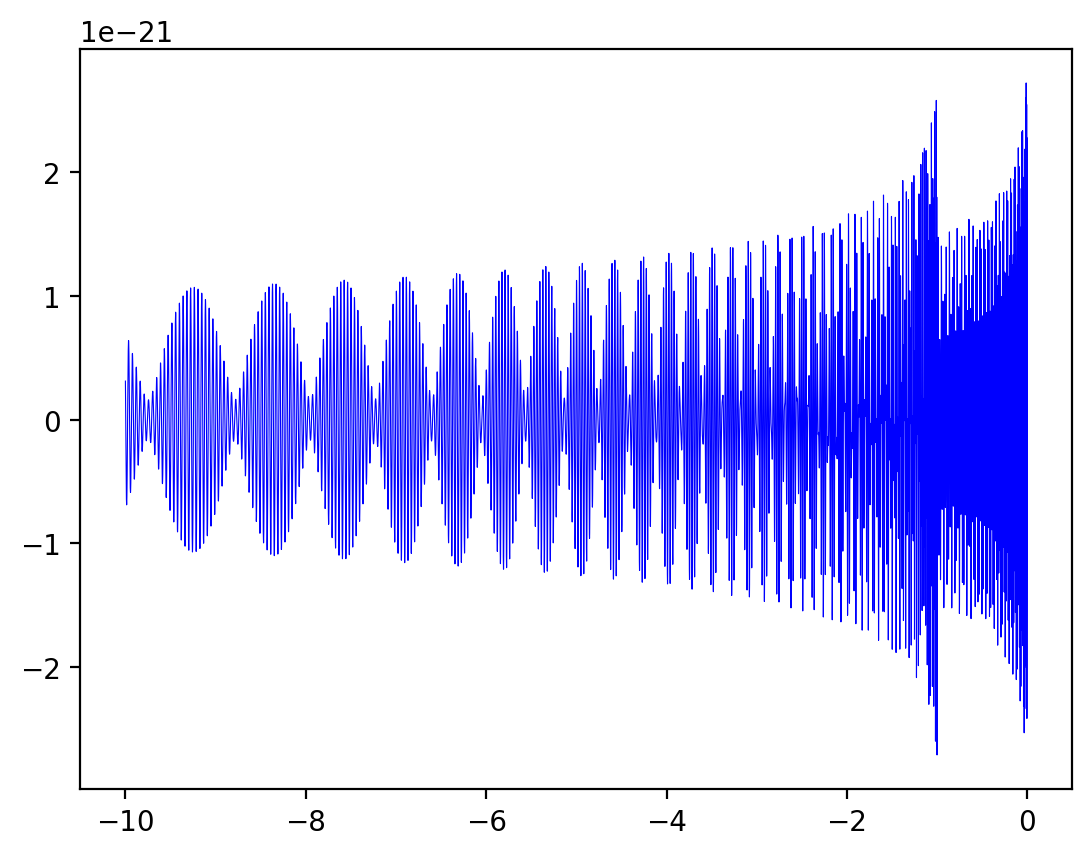

In [8]:
fig = plt.figure(dpi=200)
plt.plot(t, outResults['bestSig'], #label='BestSig',
         'blue',lw=.2*2)
plt.show()